# Notebook to run quantile matching calibration

In [1]:
# import packages

import datetime as dt
from climada import CONFIG

import util_calibration as u_calib
import utils

# maybe not smart to just hide warnings?
import warnings # To hide the warnings
warnings.filterwarnings('ignore')

/Users/vgebhart/miniforge3/envs/scclim_env/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


In [2]:
# create a list of dates Apr-Sep, 2021-2023
start_date = "2021-04-01"
end_date = "2023-09-30"
date_mode = 'all_summers'

# metric
metric = 'paa' # 'paa' or 'mdr'

# model
model = 'cosmo1e' # 'cosmo1e', 'cosmo2e', 'icon-ch1-eps', 'icon-ch2-eps'

# define directories
data_dir = str(CONFIG.local_data.data_dir)
out_dir = str(CONFIG.local_data.out_dir)
dir_impf = f"{CONFIG.local_data.data_dir}/HailCast/impf/"
dir_haz = f"{CONFIG.local_data.data_dir}/HailCast/forecast/{model}"
f_damage = f"{data_dir}/damage/ds_building_dmg_v71_1000m.nc"
n_members = 11
scatter_size = 3

def get_filepath(date):
    return f"{dir_haz}/max_66UTC/FCST{date.strftime('%y')}/{date.strftime('%m')}/DHAIL66mx_init{date.strftime('%y%m%d')}_06_val{date.strftime('%y%m%d')}_07-{(date + dt.timedelta(days=1)).strftime('%y%m%d')}_06.nc"
if model not in ["cosmo1e", "cosmo2e"]:
    def get_filepath(date):
        return f"{dir_haz}/reforecast/max_66UTC/{utils.get_icon_paths(date)[0]}"
if model not in ["cosmo1e", "icon-ch1-eps"]:
    f_damage = f"{data_dir}/damage/ds_building_dmg_v71_1000m.nc"
    n_members=21


In [3]:
# read exposure
thresh_exp = 10
exp = utils.read_xr_exposure(f_damage, 'n_count_exposure', 'count')

# read impacts
imp = utils.read_xr_impact(f_damage,'PAA')


Not all impact dates are within the selected date range. Selecting subset of impact dates.
Centroids before subsetting: 33366
Centroids after subsetting:   6708
Impact after subsetting  (events, centroids):  (142, 6708)
Number of events with reported impacts: 142

Impact after filling dates with no damages: (549, 6708)
142 events in the period: 2021-05-19 - 2023-09-22
407 of 549 days without damage
Hazard files available: 537
Hazard files missing:   12
Hazard dimensions (n_time*n_members, n_centroids): (5907, 919620)

Remove 12 dates from imp_sel which are missing in hazard dataset.
Shape of imp_sel with all dates:             (549, 6708)
Shape of imp_sel with missing dates removed: (537, 6708)
Optimization terminated successfully.
         Current function value: 0.048960
         Iterations: 108
         Function evaluations: 185
{'v_thresh': 24.565308422357354, 'v_half': 36.45070249999149, 'scale': 0.9999999998850709, 'power': 3.0}
Equiv. impact bias: -16.344%
Optimization terminate

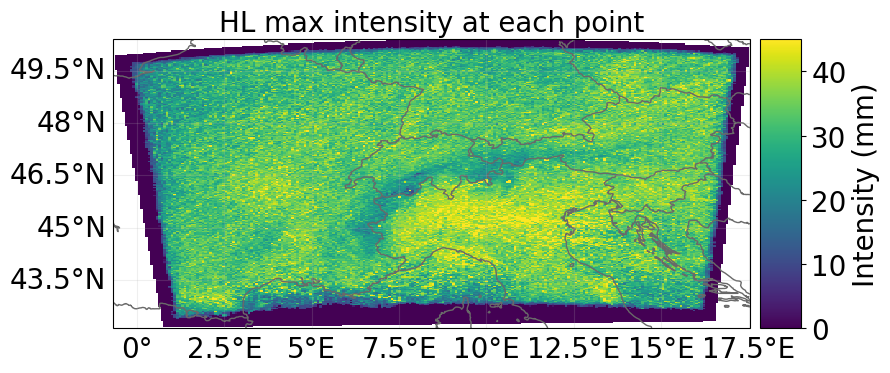

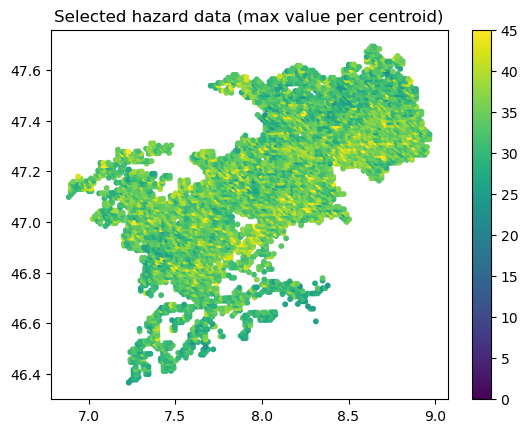

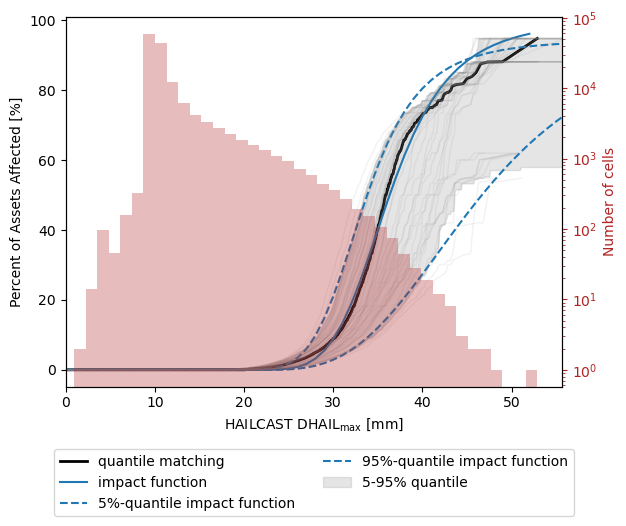

In [4]:
# run the calibration
base_path = f"{dir_impf}/i_{model}_{start_date}-{end_date}_{metric}"

params, params_flex, fig, haz_vals_sorted, bs_haz, bs_imp, haz_counts = u_calib.quantile_match_calib(
    get_filepath, exp, imp, start_date, end_date, thresh_exp, metric,
    n_members=n_members,plot_level=3,save_path=base_path,
    bs_samples= 50
)